In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from pathlib import Path
import os.path

In [3]:
# importing the data
import kagglehub

# download latest version
path = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset") # directory path

print("Path to dataset files:", path)

base_path = path  # this path comes from the API

train_dir = os.path.join(base_path, 'AugmentedAlzheimerDataset') # subdirectory (AugmentedAlzheimerDataset) inside the base path

# printing the directories to verify
print("Train Directory:", train_dir) # path to the training directory

100%|██████████| 380M/380M [00:03<00:00, 132MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1
Train Directory: /root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1/AugmentedAlzheimerDataset


In [4]:
image_dir = Path(train_dir)

# get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) # list contains all image file paths in the directory

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths)) # list will now contain labels for each image file, based on the directory names

filepaths = pd.Series(filepaths, name='Filepath').astype(str)  # converted into a Pandas Series  and cast to string type to ensure compatibility when working with the DataFrame
labels = pd.Series(labels, name='Label') # also converted into a Pandas series

# concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1) # pd.concat() concatenates the filepaths and labels Series along the column axis to create a DataFrame named image_df.

In [5]:
# identify and print out the paths of any .jpg images within base_path that cannot be opened due to being unrecognized or corrupted.
# For quality-checking the dataset and ensuring all images are valid before processing them
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(base_path).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [ ]:
image_df

,Filepath,Label
0,/root/.cache/kagglehub/datasets/uraninjo/augme...,ModerateDemented
1,/root/.cache/kagglehub/datasets/uraninjo/augme...,ModerateDemented
2,/root/.cache/kagglehub/datasets/uraninjo/augme...,ModerateDemented
3,/root/.cache/kagglehub/datasets/uraninjo/augme...,ModerateDemented
4,/root/.cache/kagglehub/datasets/uraninjo/augme...,ModerateDemented
...,...,...
33979,/root/.cache/kagglehub/datasets/uraninjo/augme...,MildDemented
33980,/root/.cache/kagglehub/datasets/uraninjo/augme...,MildDemented
33981,/root/.cache/kagglehub/datasets/uraninjo/augme...,MildDemented
33982,/root/.cache/kagglehub/datasets/uraninjo/augme...,MildDemented


In [ ]:
image_df.shape

(33984, 2)

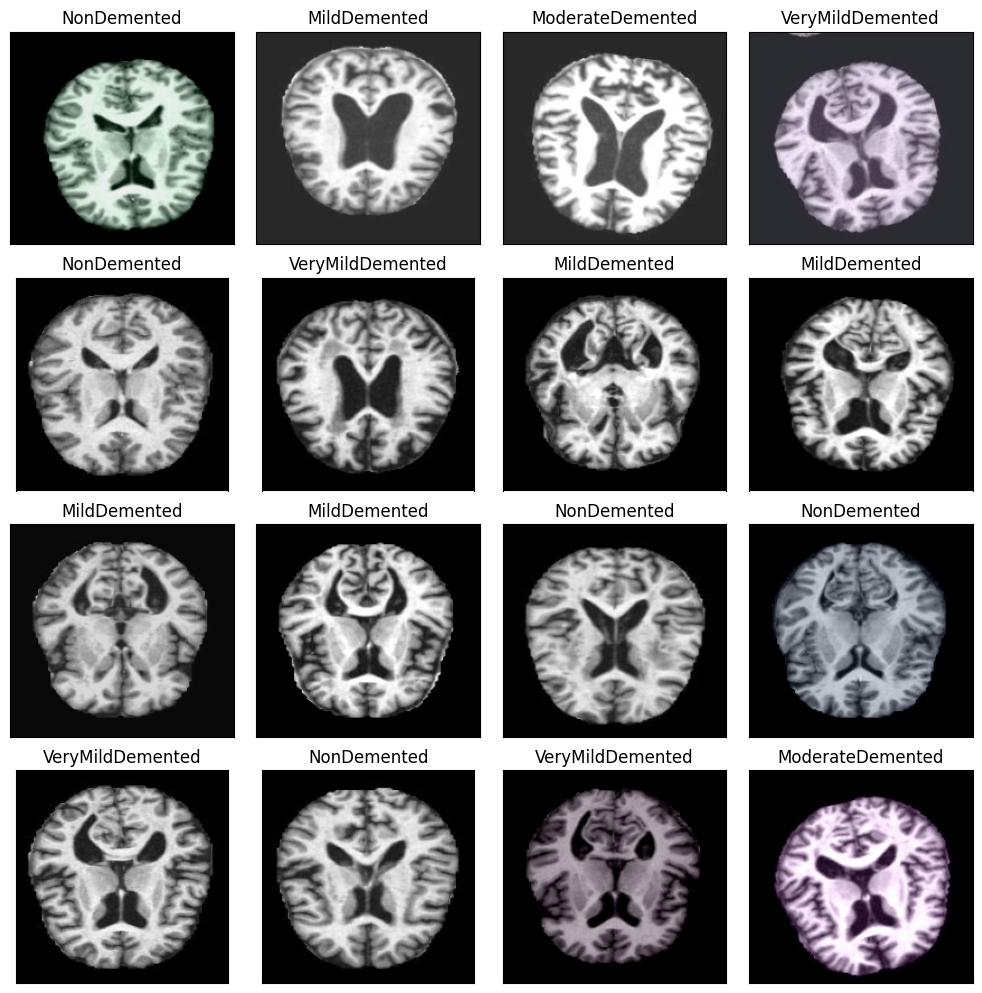

In [6]:
#  randomly select 16 images from image_df and displays them in a 4x4 grid with their labels as titles.
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [7]:
# sets up two data generators, one for training and one for validation, which will load, resize, and preprocess images from the  directory (train_dir).
# The images are rescaled, organized into batches, and split into training and validation sets to be used in model training.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# generates batches of image data with real-time data augmentation. It allows the images to be loaded and preprocessed in real-time

train_datagen = ImageDataGenerator(rescale=1./255,
    validation_split=0.2) # set validation

train_images = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), # resizes each image to 224x224 pixels
    batch_size=32, # the generator will yield batches of 32 images at a time
    class_mode='categorical', # labels are categorical, meaning the generator will one-hot encode the labels.
    subset='training', # specifies that this generator will use the 80% subset for training
    shuffle = True) # shuffle the dataset to promote model generalization

validation_images = train_datagen.flow_from_directory(
    train_dir ,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation', # specified to use the 20% of the images allocated for validation
    shuffle = False) # do no shuffle to keep consistent evaluation order

Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.


In [14]:
print(len(train_images))
print(len(validation_images))

850
213


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D

# model architecture
model = tf.keras.models.Sequential([
    Conv2D(16, (3,3), activation = 'relu', input_shape = (224,224, 3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation = 'relu'), #  fully connected layer with 512 units
    Dropout(0.2), # drops 20% of the neurons in this layer during training
    Dense(4, activation = 'softmax') # softmax for multi class
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 32)        0

In [10]:
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history = model.fit(train_images,
    steps_per_epoch=len(train_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=10)

Epoch 1/10
850/850 [==============================] - 159s 185ms/step - loss: 0.9108 - accuracy: 0.5775 - val_loss: 0.6694 - val_accuracy: 0.7017
Epoch 2/10
850/850 [==============================] - 159s 187ms/step - loss: 0.5781 - accuracy: 0.7472 - val_loss: 0.4669 - val_accuracy: 0.7993
Epoch 3/10
850/850 [==============================] - 157s 185ms/step - loss: 0.3804 - accuracy: 0.8402 - val_loss: 0.3843 - val_accuracy: 0.8334
Epoch 4/10
850/850 [==============================] - 156s 184ms/step - loss: 0.2607 - accuracy: 0.8951 - val_loss: 0.2943 - val_accuracy: 0.8763
Epoch 5/10
850/850 [==============================] - 158s 186ms/step - loss: 0.1842 - accuracy: 0.9264 - val_loss: 0.2638 - val_accuracy: 0.8979
Epoch 6/10
850/850 [==============================] - 155s 183ms/step - loss: 0.1329 - accuracy: 0.9490 - val_loss: 0.2881 - val_accuracy: 0.8927
Epoch 7/10
850/850 [==============================] - 154s 181ms/step - loss: 0.0989 - accuracy: 0.9636 - val_loss: 0.2794 -

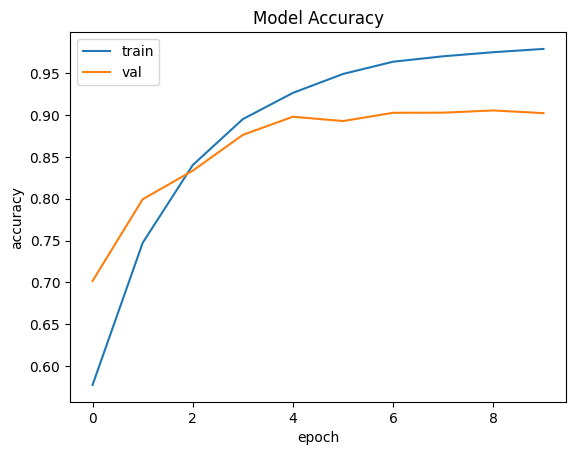

In [11]:
#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

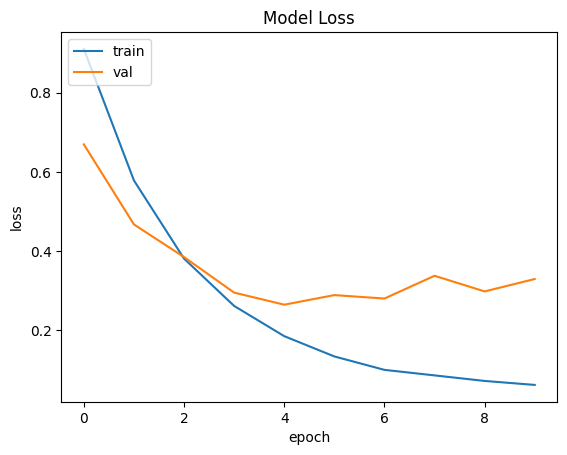

In [12]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

213/213 [==============================] - 11s 52ms/step


<Figure size 800x800 with 0 Axes>

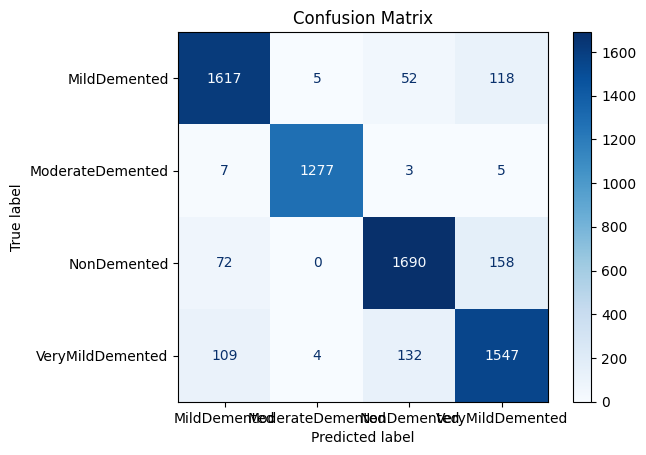

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Make predictions on validation data
# Since validation_images is a generator, we can use `predict` on the entire validation set
predictions = model.predict(validation_images)
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices

# 2. Get true labels from validation data generator
true_classes = validation_images.classes  # Original labels for the validation set

# 3. Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_images.class_indices.keys())

# 4. Plot the confusion matrix
plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()

In [14]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Get Predictions on Validation Data
predictions = model.predict(validation_images)
predicted_classes = np.argmax(predictions, axis=1)

# Get True Labels from Validation Data
true_classes = validation_images.classes

# Generate a Classification Report
report = classification_report(true_classes, predicted_classes, target_names=validation_images.class_indices.keys())
print("Classification Report:")
print(report)

# Calculate Overall Accuracy (as an additional check)
accuracy = accuracy_score(true_classes, predicted_classes)
print("Overall Accuracy:", accuracy)

213/213 [==============================] - 12s 57ms/step
Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.90      0.90      0.90      1792
ModerateDemented       0.99      0.99      0.99      1292
     NonDemented       0.90      0.88      0.89      1920
VeryMildDemented       0.85      0.86      0.85      1792

        accuracy                           0.90      6796
       macro avg       0.91      0.91      0.91      6796
    weighted avg       0.90      0.90      0.90      6796

Overall Accuracy: 0.9021483225426722


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>